In [1]:
import numpy as np;
import pandas as pd;

# evaluate adaboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
roc_auc_scoreScorer=make_scorer(roc_auc_score)
mccScorer = make_scorer(matthews_corrcoef)

from google.colab import drive
drive.mount("/content/gdrive")

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Mounted at /content/gdrive


In [2]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [3]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [4]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [5]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [6]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
def ADABoost_HP_Tuning(X,Y):
  # define the model with default hyperparameters
  model = AdaBoostClassifier()
  # define the grid of values to search
  grid = dict()
  grid['n_estimators'] = [10, 50, 100, 500]
  grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
  search = GridSearchCV(model, grid, scoring = mccScorer, cv = 2,verbose=2)
  # fit the model
  search.fit(X, Y.astype('int'))
  # summarize result
  print('Best Score: %s' % search.best_score_)
  print('Best Hyperparameters: %s' % search.best_params_)

In [7]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [8]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [9]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [12]:
def ADABoost_plain_cross_validation(X,Y,n_estimator,learning_rate,endpointLabel,numberOfFeatures=1):
  base_estimator = DecisionTreeClassifier(max_depth=3,class_weight='balanced')
  # define model
  model = AdaBoostClassifier(base_estimator=base_estimator,learning_rate=learning_rate,n_estimators=n_estimator)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-AdaBoost-RFbase-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-AdaBoost-RFbase-'+endpointLabel)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.037 SD: (0.077)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [2.48625871e+02 2.97358804e+00 3.65304958e-02 8.41176471e-01
 1.50000000e-01 3.81818182e-02 6.00000000e-02 5.10379475e-01]
SD [1.73299344 0.0231657  0.07692011 0.01714986 0.2        0.04685127
 0

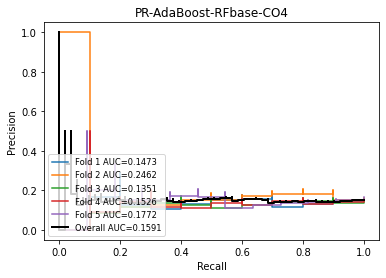

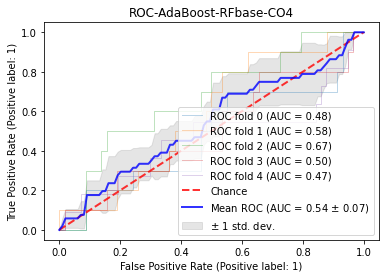

In [14]:
ADABoost_plain_cross_validation(co4['X'],co4['Y'],50,0.1,'CO4',co4['X'].shape[1])

In [ ]:
ADABoost_plain_cross_validation(co5['X'],co5['Y'],100,0.1,800,'CO5',co5['X'].shape[1])

KeyboardInterrupt: ignored

In [ ]:
ADABoost_plain_cross_validation(co6['X'],co6['Y'],100,0.1,800,'CO6',co6['X'].shape[1])

In [ ]:
def ADABoost_with_RF_cross_validation(X,Y,n_estimator,learning_rate,n_rf_estimators,endpointLabel,numberOfFeatures=1):
  # base_estimator=LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight='balanced');
  base_estimator = RandomForestClassifier(n_estimators=n_rf_estimators,random_state=1,class_weight='balanced_subsample')
  #base_estimator=LogisticRegression(class_weight='balanced');
  # define model
  model = AdaBoostClassifier(base_estimator=base_estimator,learning_rate=learning_rate,n_estimators=n_estimator)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-AdaBoost-RFbase-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-AdaBoost-RFbase-'+endpointLabel)

{'algorithm': 'SAMME.R', 'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced_subsample', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': None, 'base_estimator__max_samples': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 800, 'base_estimator__n_jobs': None, 'base_estimator__oob_score': False, 'base_estimator__random_state': 1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=800,
                       random_state=1), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.349 SD: (0.137)
['fit_time', 'score_time', 'test_mccScorer', 'tes

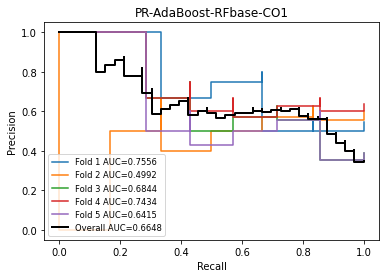

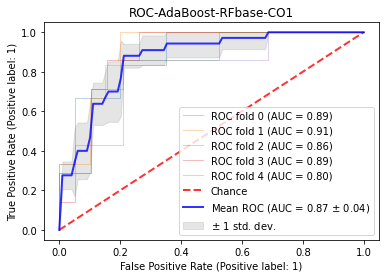

In [ ]:
ADABoost_with_RF_cross_validation(co1['X'],co1['Y'],50,0.1,800,'CO1',best_co1)

{'algorithm': 'SAMME.R', 'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced_subsample', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': None, 'base_estimator__max_samples': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 800, 'base_estimator__n_jobs': None, 'base_estimator__oob_score': False, 'base_estimator__random_state': 1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=800,
                       random_state=1), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.440 SD: (0.277)
['fit_time', 'score_time', 'test_mccScorer', 'tes

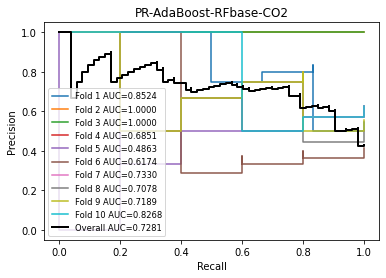

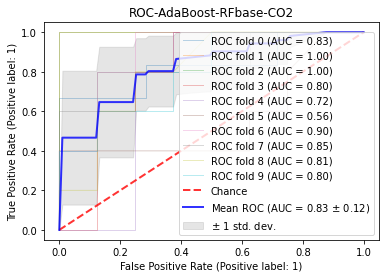

In [ ]:
ADABoost_with_RF_cross_validation(co2['X'],co2['Y'],50,0.1,800,'CO2',best_co2)

{'algorithm': 'SAMME.R', 'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced_subsample', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': None, 'base_estimator__max_samples': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 800, 'base_estimator__n_jobs': None, 'base_estimator__oob_score': False, 'base_estimator__random_state': 1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=800,
                       random_state=1), 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': None}
MCC Score- Mean: 0.278 SD: (0.057)
['fit_time', 'score_time', 'test_mccScorer', 'te

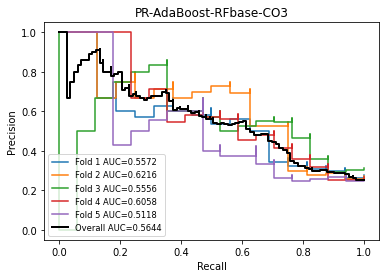

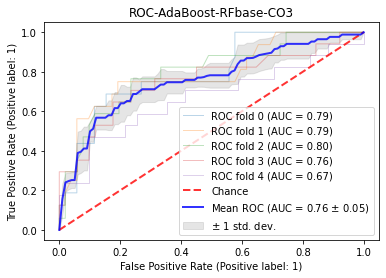

In [ ]:
ADABoost_with_RF_cross_validation(co3['X'],co3['Y'],100,0.1,800,'CO3',best_co3)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

{'algorithm': 'SAMME.R', 'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced_subsample', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': None, 'base_estimator__max_samples': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 800, 'base_estimator__n_jobs': None, 'base_estimator__oob_score': False, 'base_estimator__random_state': 1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=800,
                       random_state=1), 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': None}
MCC Score- Mean: 0.059 SD: (0.118)
['fit_time', 'score_time', 'test_mccScorer', 'te

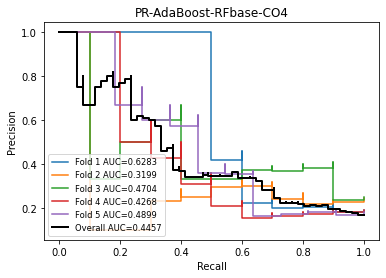

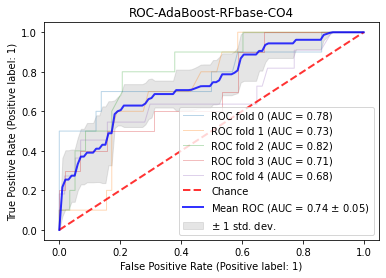

In [ ]:
ADABoost_with_RF_cross_validation(co4['X'],co4['Y'],100,0.1,800,'CO4',best_co4)

{'algorithm': 'SAMME.R', 'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced_subsample', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': None, 'base_estimator__max_samples': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 800, 'base_estimator__n_jobs': None, 'base_estimator__oob_score': False, 'base_estimator__random_state': 1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=800,
                       random_state=1), 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': None}
MCC Score- Mean: 0.828 SD: (0.039)
['fit_time', 'score_time', 'test_mccScorer', 'te

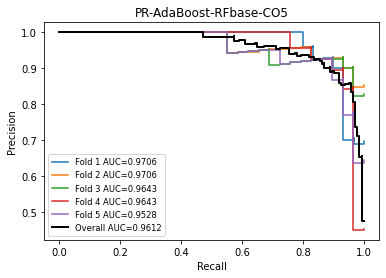

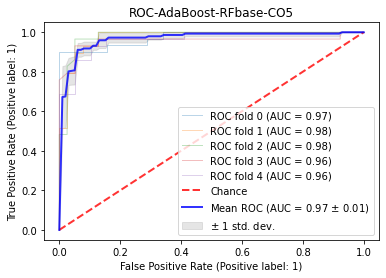

In [ ]:
ADABoost_with_RF_cross_validation(co5['X'],co5['Y'],100,0.1,800,'CO5',best_co5)

{'algorithm': 'SAMME.R', 'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': 'balanced_subsample', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': None, 'base_estimator__max_samples': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 800, 'base_estimator__n_jobs': None, 'base_estimator__oob_score': False, 'base_estimator__random_state': 1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=800,
                       random_state=1), 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': None}
MCC Score- Mean: 0.307 SD: (0.123)
['fit_time', 'score_time', 'test_mccScorer', 'te

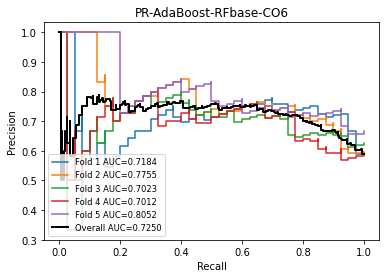

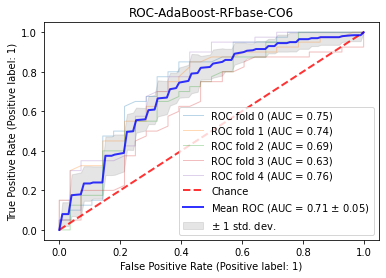

In [ ]:
ADABoost_with_RF_cross_validation(co6['X'],co6['Y'],100,0.1,800,'CO6',best_co6)

In [ ]:
def ADABoost_with_logbase_cross_validation(X,Y,C,penalty,solver,n_estimator,learning_rate,endpointLabel,numberOfFeatures=1):
  base_estimator=LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight='balanced');
  #base_estimator=LogisticRegression(class_weight='balanced');
  # define model
  model = AdaBoostClassifier(base_estimator=base_estimator,learning_rate=learning_rate,n_estimators=n_estimator)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-AdaBoost-Logregbase-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-AdaBoost-Logregbase-'+endpointLabel)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'algorithm': 'SAMME.R', 'base_estimator__C': 1e-05, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'none', 'base_estimator__random_state': None, 'base_estimator__solver': 'newton-cg', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1e-05, class_weight='balanced', penalty='none',
                   solver='newton-cg'), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.598 SD: (0.133)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.3971611  0.02883506 0.59767891 0.84615385 0.73809524 0.66666667
 0.69406593 0.78675439]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

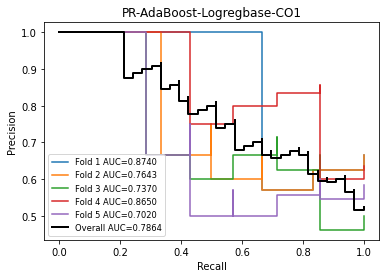

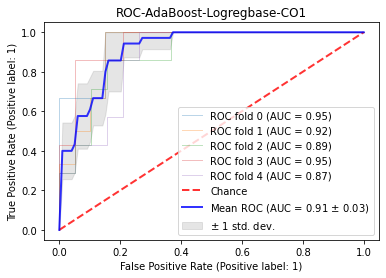

In [ ]:
ADABoost_with_logbase_cross_validation(co1['X'],co1['Y'],1e-05, 'none','newton-cg',50,0.1,'CO1')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'algorithm': 'SAMME.R', 'base_estimator__C': 1e-05, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'none', 'base_estimator__random_state': None, 'base_estimator__solver': 'newton-cg', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1e-05, class_weight='balanced', penalty='none',
                   solver='newton-cg'), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.609 SD: (0.127)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.15406766 0.01617465 0.60942361 0.84615385 0.73095238 0.7
 0.70432234]
SD [0.01643434 0.00054214 0.126760

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

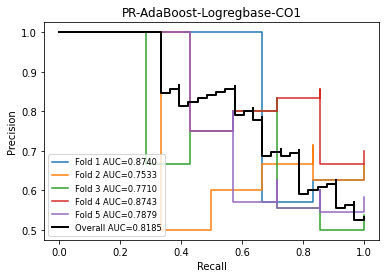

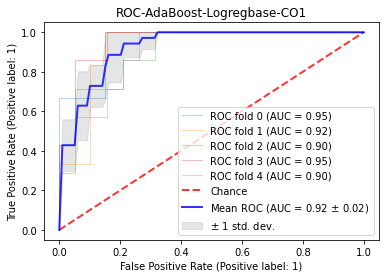

In [ ]:
ADABoost_with_logbase_cross_validation(co1['X'],co1['Y'],1e-05, 'none','newton-cg',50,0.1,'CO1',best_co1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

{'algorithm': 'SAMME.R', 'base_estimator__C': 0.1, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l1', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.000 SD: (0.000)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [6.36197214 0.52956352 0.         0.59230769 0.         0.
 0.         0.5       ]
SD [0.00641139 0

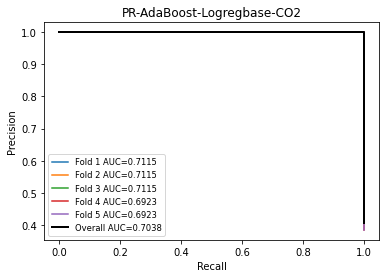

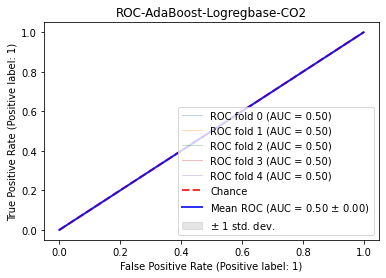

In [ ]:
ADABoost_with_logbase_cross_validation(co2['X'],co2['Y'],0.1, 'l1','liblinear',50,0.1,'CO2')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

{'algorithm': 'SAMME.R', 'base_estimator__C': 0.1, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l1', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.000 SD: (0.000)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [2.48383904 0.25791745 0.         0.59230769 0.         0.
 0.         0.5       ]
SD [0.01321692 0

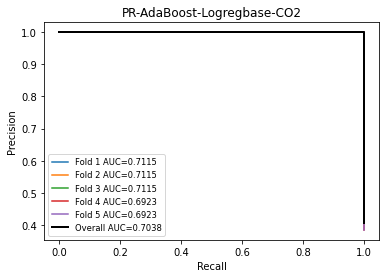

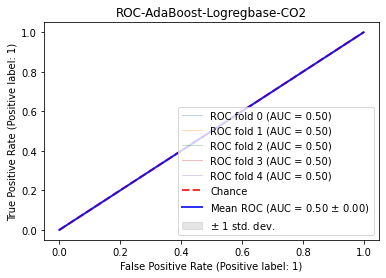

In [ ]:
ADABoost_with_logbase_cross_validation(co2['X'],co2['Y'],0.1, 'l1','liblinear',50,0.1,'CO2',best_co2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'algorithm': 'SAMME.R', 'base_estimator__C': 1.0, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(class_weight='balanced'), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.538 SD: (0.082)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.90682306 0.07132149 0.5379812  0.83529412 0.68914835 0.60220588
 0.64      ]
SD [0.03935062 0.00327662 0.08233558 0.02851576 0.07600186 0.0802246
 0.06526416]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


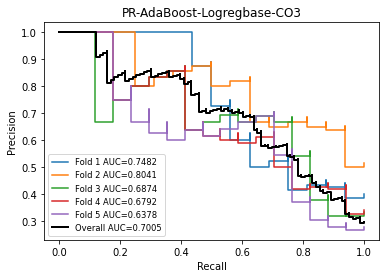

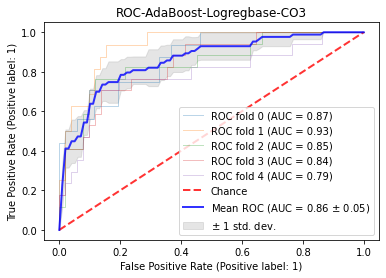

In [ ]:
ADABoost_with_logbase_cross_validation(co3['X'],co3['Y'],1e-05, 'none','newton-cg',50,0.1,'CO3',best_co3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'algorithm': 'SAMME.R', 'base_estimator__C': 1.0, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(class_weight='balanced'), 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': None}
MCC Score- Mean: 0.504 SD: (0.093)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.6935915  0.06418943 0.50448123 0.88529412 0.71555556 0.45090909
 0.54526316]
SD [0.05641234 0.00201203 0.0930116  0.02530096 0.16830308 0.0447583
 0.06218946]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


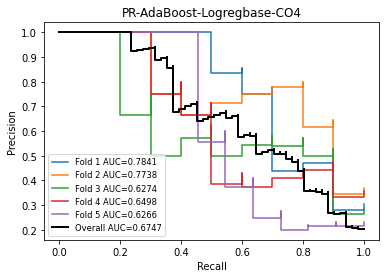

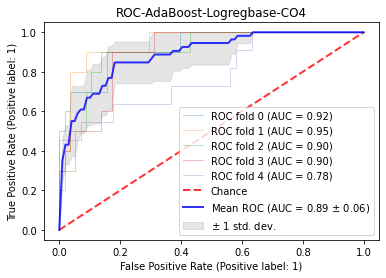

In [ ]:
ADABoost_with_logbase_cross_validation(co4['X'],co4['Y'],1, 'l2','lbfgs',50,0.1,'CO4',best_co4)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'algorithm': 'SAMME.R', 'base_estimator__C': 1.0, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(class_weight='balanced'), 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': None}
MCC Score- Mean: 0.888 SD: (0.039)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.41766329 0.04814076 0.88753092 0.94411765 0.92145929 0.95218391
 0.93614035]
SD [0.03594536 0.00198622 0.03937633 0.01950956 0.03179195 0.02725471
 0.02181655]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


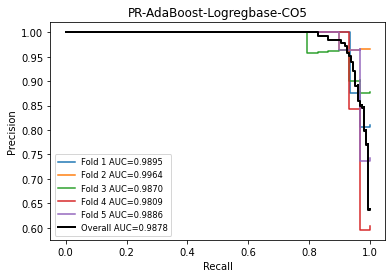

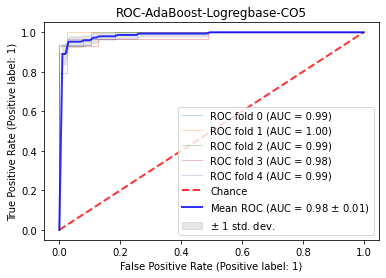

In [ ]:
ADABoost_with_logbase_cross_validation(co5['X'],co5['Y'],0.01, 'l1','liblinear',100,0.1,'CO5',best_co5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'algorithm': 'SAMME.R', 'base_estimator__C': 1.0, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(class_weight='balanced'), 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': None}
MCC Score- Mean: 0.538 SD: (0.092)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.60818357 0.05247092 0.53845419 0.77647059 0.7948149  0.835
 0.81349908]
SD [0.03502521 0.00235542 0.09210015 0.0440195  0.0249235  0.06819091
 0.04075333]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


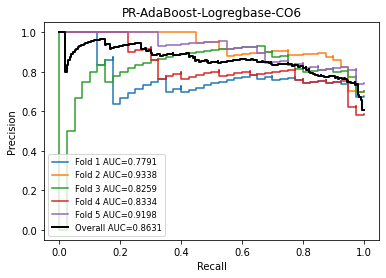

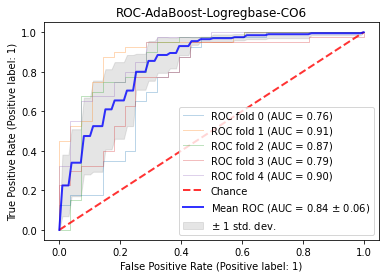

In [ ]:
ADABoost_with_logbase_cross_validation(co6['X'],co6['Y'],1e-05, 'l2','lbfgs',100,0.1,'CO6',best_co6)

In [ ]:
ADABoost_HP_Tuning(**co1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.0001, n_estimators=10, total=   2.3s
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ............ learning_rate=0.0001, n_estimators=10, total=   2.3s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total=  10.4s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total=  10.4s
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total=  20.6s
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total=  20.7s
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total= 1.7min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total= 1.7min
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ............... learning_rate=0.1, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=  10.4s
[CV] learning_rate=0.1, n_estimators=50 ..............................


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ............... learning_rate=0.1, n_estimators=50, total=  10.5s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=  20.9s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=  20.7s
[CV] learning_rate=0.1, n_estimators=500 .............................
[CV] .............. learning_rate=0.1, n_estimators=500, total= 1.7min
[CV] learning_rate=0.1, n_estimators=500 .............................
[CV] .............. learning_rate=0.1, n_estimators=500, total= 1.7min
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] ............... learning_rate=1.0, n_estimators=10, total=   2.3s
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] ............... learning_rate=1.0, n_estimators=10, total=   2.2s
[CV] learning_rate=1.0, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 22.6min finished


Best Score: 0.268407305443886
Best Hyperparameters: {'learning_rate': 1.0, 'n_estimators': 10}


In [ ]:
ADABoost_HP_Tuning(**co2)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.0001, n_estimators=10, total=   3.2s
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ............ learning_rate=0.0001, n_estimators=10, total=   2.4s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total=  10.5s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total=  10.5s
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total=  20.9s
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total=  20.8s
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total= 1.7min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total= 1.7min
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 22.7min finished


Best Score: 0.30521945537837086
Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 100}


In [ ]:
ADABoost_HP_Tuning(**co3)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  17.4s
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  17.2s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.7min
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 157.0min finished


Best Score: 0.20374684041504534
Best Hyperparameters: {'learning_rate': 0.0001, 'n_estimators': 500}


In [ ]:
ADABoost_HP_Tuning(**co4)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  16.6s
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  16.5s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ............. learning_rate=0.01, n_estimators=100, total= 2.4min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total= 2.4min
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV] ............. learning_rate=0.01, n_estimators=500, total=11.8min
[CV] learning_rate=0.01, n_estimators=500 ............................


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ............. learning_rate=0.01, n_estimators=500, total=11.8min
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] ............... learning_rate=0.1, n_estimators=10, total=  16.8s
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] ............... learning_rate=0.1, n_estimators=10, total=  16.7s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total= 1.2min
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total= 1.3min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total= 2.4min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total= 2.4min
[CV] learning_rate=0.1, n_estimators=500 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 156.9min finished


Best Score: 0.10609655158068548
Best Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 500}


In [ ]:
ADABoost_HP_Tuning(**co5)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  16.6s
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  16.6s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 156.6min finished


Best Score: 0.8238749607268134
Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 100}


In [ ]:
ADABoost_HP_Tuning(**co6)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  16.6s
[CV] learning_rate=0.0001, n_estimators=10 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV] ............ learning_rate=0.0001, n_estimators=10, total=  16.4s
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=50 ...........................
[CV] ............ learning_rate=0.0001, n_estimators=50, total= 1.2min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=100 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=100, total= 2.4min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.0001, n_estimators=500 ..........................
[CV] ........... learning_rate=0.0001, n_estimators=500, total=11.8min
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV] .